# Audio to emotion
#####An emotion recoginition model using audio files from RAVDESS database.
#####RAVDESS: https://zenodo.org/record/1188976
#####Reference: https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition
#####Reference: A2 Assignement https://colab.research.google.com/drive/164XHQR1ywKak79HoyXOBqHQ9v7UtVTVs

In [ ]:
import os
import pandas as pd
import random
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from IPython.core.display import display
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
import keras.layers as layers
import keras as keras
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Dense, Embedding
from keras.layers import Dense, Dropout, Embedding, LSTM, BatchNormalization, Flatten, MaxPooling2D
from keras.callbacks import *
!pip install pyyaml h5py
!pip install joblib
from joblib import dump, load

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Import audio files from google drive
####since we don't have access to share drive, the audio data zip file has to be uploaded to our own drive with path.

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip -u "/content/drive/MyDrive/audio/Audio_Speech_Actors_01-24.zip" -d "/content/drive/MyDrive/audio/Audio_Speech_Actors_01-24"

Archive:  /content/drive/MyDrive/audio/Audio_Speech_Actors_01-24.zip


In [ ]:
#read file path
paths, emotions, duration = [], [], []

for dir, _, filenames in os.walk('/content/drive/MyDrive/audio/Audio_Speech_Actors_01-24'):
  for filename in filenames:
    paths.append(os.path.join(dir, filename))
    duration.append(round(librosa.get_duration(filename=paths[-1]), 3)) 
    label = filename[::-1].split('_')[0][::-1]
    
    if label[6:8] == '01':
      emotions.append('neutral')
    elif label[6:8] == '02':
      emotions.append('calm')
    elif label[6:8] == '03':
      emotions.append('happy')
    elif label[6:8] == '04':
      emotions.append('sad')
    elif label[6:8] == '05':
      emotions.append('angry')
    elif label[6:8] == '06':
      emotions.append('fear')
    elif label[6:8] == '07':
      emotions.append('disgust')
    elif label[6:8] == '08':
      emotions.append('surprise')     

In [ ]:
ravdess = pd.DataFrame({'path': paths, 'duration':duration, 'emotion': emotions})
ravdess.sample(6)

,path,duration,emotion
1108,/content/drive/MyDrive/audio/Audio_Speech_Acto...,3.737,angry
1197,/content/drive/MyDrive/audio/Audio_Speech_Acto...,3.737,surprise
1172,/content/drive/MyDrive/audio/Audio_Speech_Acto...,3.403,fear
415,/content/drive/MyDrive/audio/Audio_Speech_Acto...,3.337,surprise
1406,/content/drive/MyDrive/audio/Audio_Speech_Acto...,3.804,sad
1032,/content/drive/MyDrive/audio/Audio_Speech_Acto...,3.837,calm


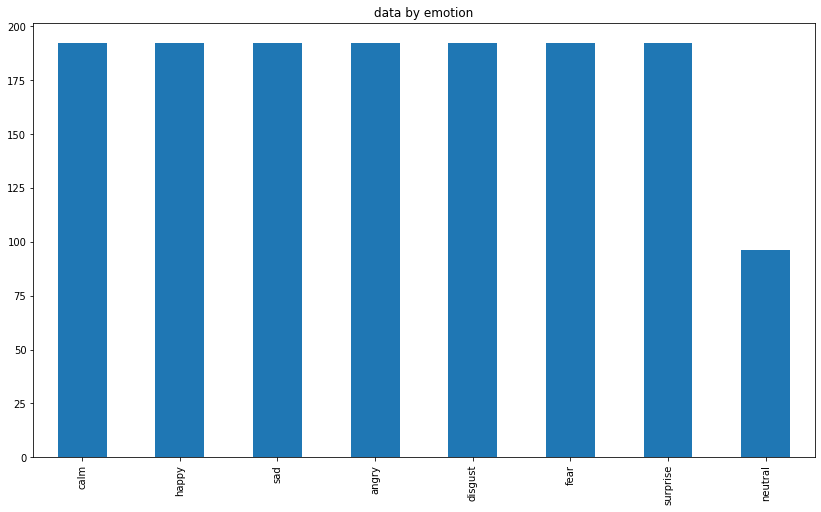

In [ ]:
count_emotion = ravdess['emotion'].value_counts()
count_emotion.plot(kind = 'bar', title = 'data by emotion', figsize=(14,8))

In [ ]:
df = ravdess

##Visualize the audio data 

In [ ]:
labels = list(df['emotion'].unique())
labels

['neutral', 'calm', 'happy', 'sad', 'angry', 'disgust', 'fear', 'surprise']

In [ ]:
#extract the filepath of first sample from each class 
files = dict()
for i in range(len(labels)):
    name = df[df['emotion'] == labels[i]][:1].reset_index()
    #print(name)
    path = '{}'.format(name['path'][0])
    files[labels[i]] = path

In [ ]:
SAMPLE_RATE = 16000
#play an audio file from each class
for i, label in enumerate(labels[:8]):
  fn = files[label]
  signal, sr = librosa.load(fn, sr = SAMPLE_RATE)
  print(f"Emotion:{label}")
  ipd.display(ipd.Audio(signal, rate = SAMPLE_RATE))

Emotion:neutral


Emotion:calm


Emotion:happy


Emotion:sad


Emotion:angry


Emotion:disgust


Emotion:fear


Emotion:surprise


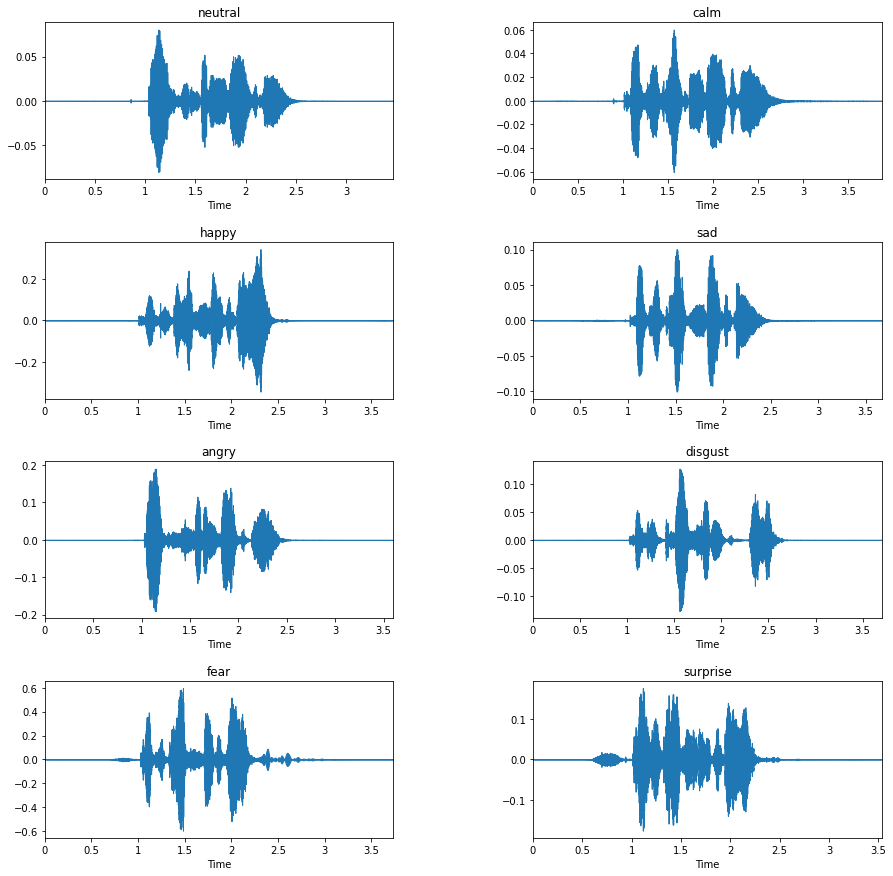

In [ ]:
#plot the first sample from each class
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels[:8]):
    fn = files[label]
    fig.add_subplot(4, 2, i+1)
    plt.title(label)
    data, sample_rate = librosa.load(fn, sr = SAMPLE_RATE, mono = True)
    librosa.display.waveplot(data, sr=SAMPLE_RATE)
    #plt.ylim(-0.75,0.75)

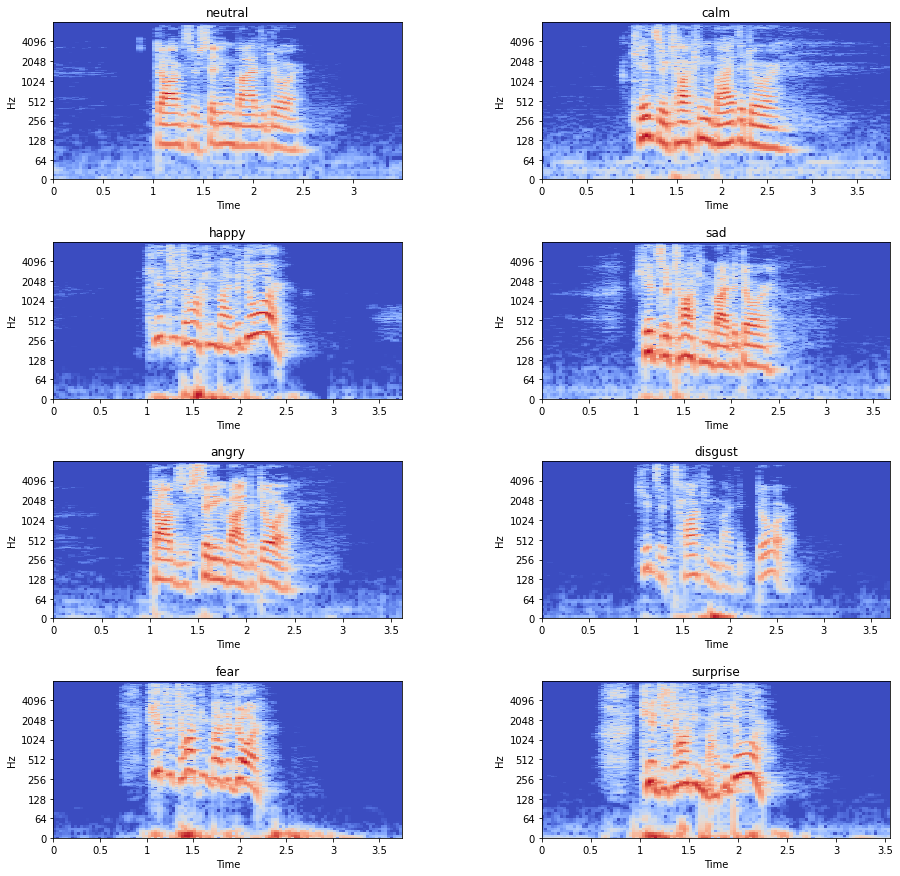

In [ ]:
n_fft = 2048
HOP_SIZE = 512

fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels[:8]):
    fn = files[label]
    fig.add_subplot(4, 2, i+1)
    plt.title(label)
    data, sample_rate = librosa.load(fn, sr = 16000, mono = True)
    #add normalization
    norm_factor = 1 / np.max(np.abs(data))
    data = data * norm_factor
    ###
    stft = np.abs(librosa.stft(data, n_fft=n_fft, hop_length=HOP_SIZE, win_length = n_fft, window = 'hann')) #short-time fourier transform
    db = librosa.amplitude_to_db(stft) #translate from amplitude to desible(db) value
    librosa.display.specshow(db, sr=16000, y_axis='log', x_axis='time')

##Data Augmentation
####The goal of data augmentation is to make the model invariant to perturbations and enhance generalization. We create new synthetic data samples by adding noise, stretching, changing pitch.


In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

####1. randomly pick an audio.

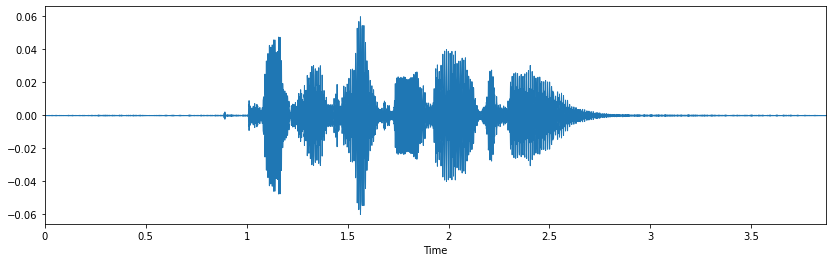

In [ ]:
# taking any example and checking for techniques.
path = np.array(df.path)[1]
data, sample_rate = librosa.load(path)
ipd.display(ipd.Audio(data, rate = sample_rate))
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)

####2. Add noise to the audio

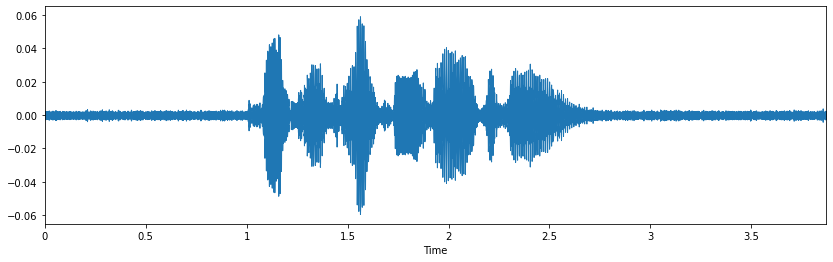

In [ ]:
x = noise(data)
ipd.display(ipd.Audio(x, rate = sample_rate))
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)

####3.Stretching the audio

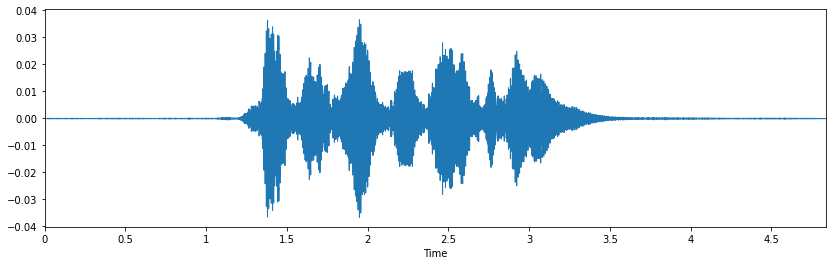

In [ ]:
x = stretch(data)
ipd.display(ipd.Audio(x, rate = sample_rate))
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)

####4.Changing the Pitch of the audio

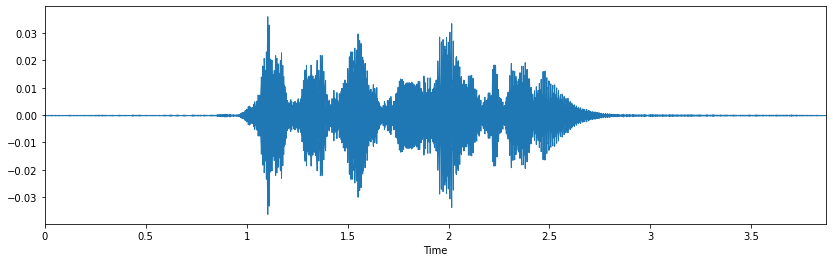

In [ ]:
x = pitch(data, sample_rate)
ipd.display(ipd.Audio(x, rate = sample_rate))
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)

##Feature Enigneering


> 13 MFCCs: Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

> Chroma: A chroma vector (Wikipedia) is a typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, ..., B}, is present in the signal.


> Root Mean Square



> spectral centroid: The center of gravity of the spectrum.



In [ ]:
def extract_features(data):
    result = np.array([])
   
    # 13 MFCCs
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=16000, n_mfcc = 13).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=16000).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # spectral centroid
    spec = np.mean(librosa.feature.spectral_centroid(y = data, sr = 16000, n_fft = 1024, hop_length = 512)[0])
    result = np.hstack((result, spec)) # stacking horizontally
    
    return result

In [ ]:
def get_features(path):
    # use duration and offset to take care of no audio at the start and the ending of each audio
    data, sample_rate = librosa.load(path, duration=2.8, offset=0.1)
    
    # without augmentation
    origin = extract_features(data)
    result = np.array(origin)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(df.path, df.emotion):
    feature = get_features(path)
    for element in feature:
        X.append(element)
        Y.append(emotion)

In [ ]:
len(X), len(Y), df.path.shape

(4320, 4320, (1440,))

In [ ]:
features = pd.DataFrame(X)
features['labels'] = Y
features.to_csv('features.csv', index=False)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,labels
0,-588.291565,82.654297,5.930445,18.200047,11.607293,4.158500,16.282320,8.565514,-11.650372,1.734011,...,0.662473,0.634607,0.612695,0.638460,0.623747,0.666571,0.691960,0.005630,1422.530357,neutral
1,-393.004099,31.784961,11.460067,9.479462,4.671604,1.703796,4.144253,1.767795,-4.353657,-2.799976,...,0.745938,0.731754,0.743802,0.767172,0.762391,0.809244,0.809431,0.006221,3027.708784,neutral
2,-642.449524,80.114243,3.734037,18.647400,7.391987,3.292181,15.161198,2.446895,-13.897610,1.605056,...,0.652663,0.631603,0.590963,0.624926,0.589894,0.580445,0.624868,0.002754,1489.234521,neutral
3,-579.094849,83.394753,9.164721,24.363268,14.267087,10.880464,12.510373,5.642864,-8.510874,5.222008,...,0.722225,0.679254,0.689339,0.705138,0.719466,0.641740,0.641534,0.005223,1398.339489,calm
4,-366.592291,25.572621,15.229788,11.620376,7.142870,4.081750,3.112478,0.332021,-1.458186,-2.086824,...,0.773996,0.787911,0.794680,0.836389,0.839814,0.835988,0.791344,0.006062,3151.750144,calm


In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4320 non-null   float64
 1   1       4320 non-null   float64
 2   2       4320 non-null   float64
 3   3       4320 non-null   float64
 4   4       4320 non-null   float64
 5   5       4320 non-null   float64
 6   6       4320 non-null   float64
 7   7       4320 non-null   float64
 8   8       4320 non-null   float64
 9   9       4320 non-null   float64
 10  10      4320 non-null   float64
 11  11      4320 non-null   float64
 12  12      4320 non-null   float64
 13  13      4320 non-null   float64
 14  14      4320 non-null   float64
 15  15      4320 non-null   float64
 16  16      4320 non-null   float64
 17  17      4320 non-null   float64
 18  18      4320 non-null   float64
 19  19      4320 non-null   float64
 20  20      4320 non-null   float64
 21  21      4320 non-null   float64
 22  

Following modules refer to the Speech Emotion Recogition tutorial by SHIVAM BURNWAL
#####Reference: https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition

##Data Preparation 


> encode Y

> split the data into train and test set

> scale the data using standard scaler



In [ ]:
X = features.iloc[: ,:-1].values
Y = features['labels'].values

In [ ]:
#encode Y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=1, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 27), (3240, 8), (1080, 27), (1080, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 27), (3240, 8), (1080, 27), (1080, 8))

In [ ]:
from joblib import dump, load
dump(scaler, 'std_scaler.bin', compress=True)
# save the scaler
dump(scaler, open('/content/drive/MyDrive/audio/scaler.pkl', 'wb'))

In [ ]:
# reshape the data to feed in the model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 27, 1), (3240, 8), (1080, 27, 1), (1080, 8))

##Modelling

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 27, 256)           1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 256)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 128)            163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 4, 128)           0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0001)
history=model.fit(x_train, y_train, batch_size=64, epochs=35, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/35
51/51 [==============================] - 10s 161ms/step - loss: 2.0317 - accuracy: 0.1806 - val_loss: 1.9391 - val_accuracy: 0.2056 - lr: 0.0010
Epoch 2/35
51/51 [==============================] - 8s 166ms/step - loss: 1.9280 - accuracy: 0.2265 - val_loss: 1.8699 - val_accuracy: 0.2657 - lr: 0.0010
Epoch 3/35
51/51 [==============================] - 7s 145ms/step - loss: 1.8400 - accuracy: 0.2608 - val_loss: 1.7809 - val_accuracy: 0.2759 - lr: 0.0010
Epoch 4/35
51/51 [==============================] - 7s 143ms/step - loss: 1.7724 - accuracy: 0.2957 - val_loss: 1.7435 - val_accuracy: 0.3046 - lr: 0.0010
Epoch 5/35
51/51 [==============================] - 7s 144ms/step - loss: 1.7404 - accuracy: 0.3142 - val_loss: 1.6799 - val_accuracy: 0.3454 - lr: 0.0010
Epoch 6/35
51/51 [==============================] - 7s 145ms/step - loss: 1.6854 - accuracy: 0.3324 - val_loss: 1.6252 - val_accuracy: 0.3639 - lr: 0.0010
Epoch 7/35
51/51 [==============================] - 7s 143ms/step - l

34/34 [==============================] - 1s 15ms/step - loss: 1.4921 - accuracy: 0.5667
Accuracy of our model on test data :  56.66666626930237 %


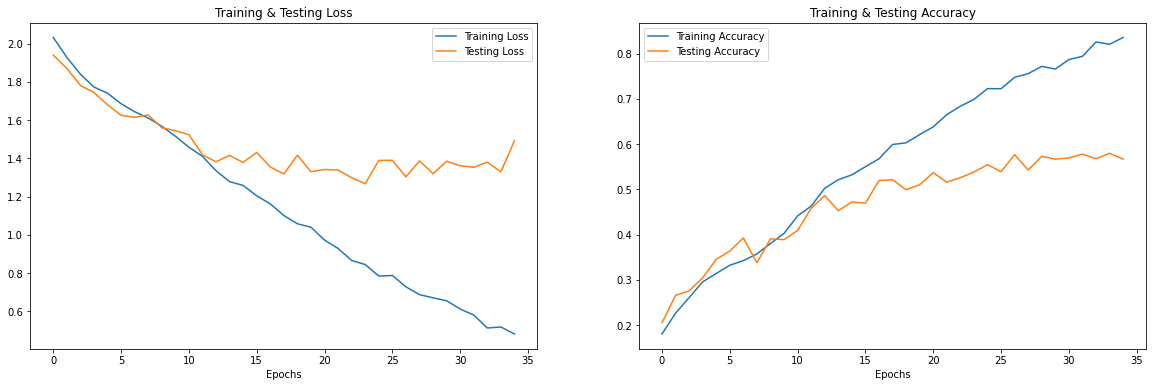

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(35)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 1s 13ms/step


In [ ]:
df_predict = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_predict['Predicted Labels'] = y_pred.flatten()
df_predict['Actual Labels'] = y_test.flatten()

df_predict.tail(5)

,Predicted Labels,Actual Labels
1075,angry,angry
1076,disgust,angry
1077,happy,happy
1078,sad,sad
1079,fear,fear


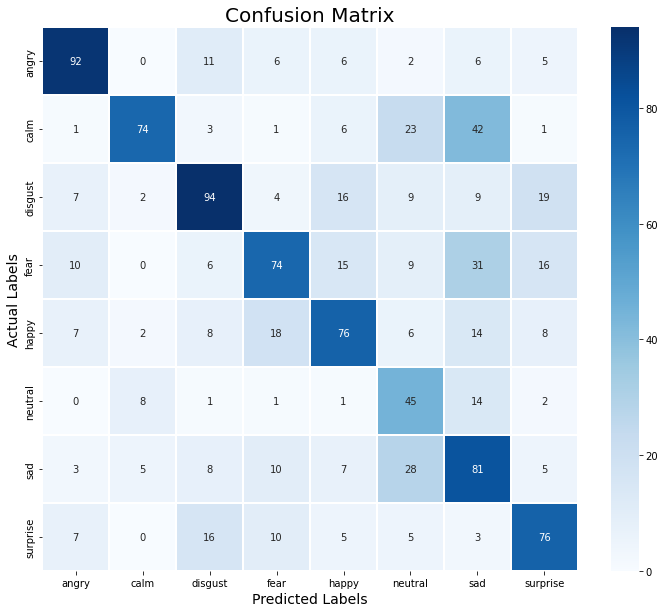

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.72      0.72      0.72       128
        calm       0.81      0.49      0.61       151
     disgust       0.64      0.59      0.61       160
        fear       0.60      0.46      0.52       161
       happy       0.58      0.55      0.56       139
     neutral       0.35      0.62      0.45        72
         sad       0.41      0.55      0.47       147
    surprise       0.58      0.62      0.60       122

    accuracy                           0.57      1080
   macro avg       0.59      0.58      0.57      1080
weighted avg       0.60      0.57      0.57      1080



##save the audio2emtion model

In [ ]:
model.save("/content/drive/MyDrive/audio/audio_model.h5")